### Import Data

In [3]:
from pathlib import Path 
import email 
import pandas as pd
from chardet.universaldetector import UniversalDetector 

message_formats = ["[0-9][0-9][0-9][0-9].*", "[0-9][0-9][0-9][0-9][0-9].*"]
paths = []

for message_format in message_formats:
    paths += list(Path("./SpamAssassinMessages/").rglob(message_format))

df = pd.DataFrame(paths, columns=["path"], dtype=str)

In [11]:
from tqdm import tqdm


In [4]:
df.path.head()

0    SpamAssassinMessages/spam/0355.94ebf637e4bd3db...
1    SpamAssassinMessages/spam/0395.bb934e8b4c39d5e...
2    SpamAssassinMessages/spam/0485.902136727883317...
3    SpamAssassinMessages/spam/0343.0630afbe4ee1ffd...
4    SpamAssassinMessages/spam/0125.44381546181fc6c...
Name: path, dtype: object

In [5]:
df['label'] = df['path'].str.contains(r"/spam(?:_\d)?/", regex=True)

In [6]:
df['label'].value_counts()

label
False    6951
True     2397
Name: count, dtype: int64

In [7]:
def get_message_chardet(p):
    detector = UniversalDetector()
    with open(p, 'rb') as f:
        detector = UniversalDetector()
        for l in f.readlines():
            detector.feed(l)
            if detector.done: break
    detector.close()
    return detector.result

def get_message_data(p):
    ct = []
    cc = []
    pl = []
    e = get_message_chardet(p)
    with open(p, encoding=e['encoding'], errors='ignore') as f:
        m = email.message_from_file(f)
        for part in m.walk():
            if not part.is_multipart():
                ct.append(part.get_content_type())
                cc.append(part.get_content_charset())
                pl.append(part.get_payload())
    return e['encoding'], e['confidence'], e['language'], ct, cc, pl

In [13]:
df[['encoding', 'encoding_confidence', 'encoding_language', 'content_type', 'content_charset', 'content']] = df.progress_apply(lambda r: get_message_data(r.path), axis='columns', result_type='expand')

AttributeError: 'DataFrame' object has no attribute 'progress_apply'

In [15]:
from tqdm.notebook import tqdm
tqdm.pandas(desc="Processing emails")


df[['encoding', 'encoding_confidence', 'encoding_language', 'content_type', 'content_charset', 'content']] = df.apply(lambda r: get_message_data(r.path), axis=1, result_type='expand')


In [16]:
df = df.explode(['content_type', 'content_charset', 'content'])
df = df.reset_index(drop=True)

In [17]:
df.head()

,path,label,encoding,encoding_confidence,encoding_language,content_type,content_charset,content
0,SpamAssassinMessages/spam/0355.94ebf637e4bd3db...,True,ISO-8859-1,0.73,,text/plain,us-ascii,"Friend,Now you can copy DVD's and Games\nhttp:..."
1,SpamAssassinMessages/spam/0355.94ebf637e4bd3db...,True,ISO-8859-1,0.73,,text/html,us-ascii,<HTML><HEAD><TITLE>Backup your DVD's</TITLE>\n...
2,SpamAssassinMessages/spam/0395.bb934e8b4c39d5e...,True,ascii,1.00,,text/plain,windows-1252,Pocket the newest 8 year annuity!\t Pocket th...
3,SpamAssassinMessages/spam/0395.bb934e8b4c39d5e...,True,ascii,1.00,,text/html,iso-8859-1,<html>\n<head>\n<title>5% Guaranteed for Eight...
4,SpamAssassinMessages/spam/0485.902136727883317...,True,ascii,1.00,,text/html,us-ascii,<html><head>\n<title>Congratulations! You Get ...


In [18]:
df['encoding'].value_counts()

encoding
ascii           9165
ISO-8859-1       510
Windows-1252     229
GB2312            17
ISO-2022-JP       12
utf-8             11
CP949             10
Big5               9
SHIFT_JIS          8
EUC-KR             8
Windows-1254       5
TIS-620            2
ISO-8859-9         2
EUC-JP             2
windows-1255       1
Name: count, dtype: int64

In [19]:
df['content_charset'].value_counts()

content_charset
us-ascii           3555
iso-8859-1         2493
windows-1252        321
iso-8859-15         104
utf-8                34
big5                 33
gb2312               18
default              15
iso-8859-2           13
windows-1251         11
iso-2022-jp          10
default_charset      10
ks_c_5601-1987        7
koi8-r                6
windows-1254          6
iso-8859-9            4
unknown-8bit          2
iso-8859-3            1
gb2312_charset        1
windows-1256          1
chinesebig5           1
euc-kr                1
Name: count, dtype: int64

### EDA

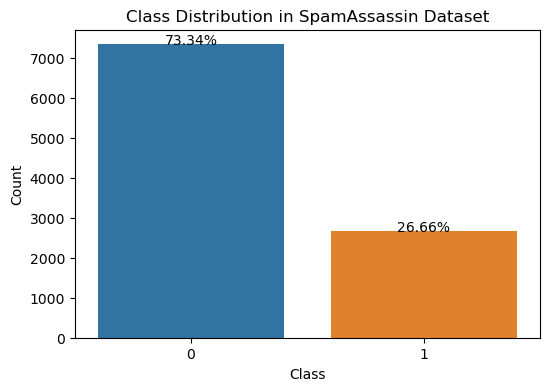

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = df['label'].value_counts()
total_samples = len(df)

plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='label')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,
            f'{height / total_samples:.2%}', ha="center")

plt.title('Class Distribution in SpamAssassin Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Clean Data

In [20]:
df['content'][0]

"Friend,Now you can copy DVD's and Games\nhttp://www.terra.es/personal9/iop1008/\n\nBACKUP DVD VIDEO's WITH YOUR CD-R BURNER\n\nWith 321 studio's software, you can now copy\nany DVD and Playstation Game.  Never buy another \nbackup DVD movie again.  Just copy it!\n\nThis is the first time this software is being made\navailable to the public. All the software you need \nto burn your own DVD Video, is included in 321 Studio's \nsoftware package DVD Copy Plus!  The movies will play \nin a standard DVD player. With detailed, easy to follow, \nstep-by-step instructions, you can BURN your own DVD \nVideo using nothing more than your DVD-ROM \nand CD-R drives. Purchase a copy! Click below.\n\nhttp://www.terra.es/personal9/iop1008/\n\nOrder today and receive!\n\n*Step by Step Interactive Instructions\n*All Software Tools Included On CD\n*No DVD Burner Required\n*FREE Live Technical Support\n*30 Day Risk Free Trial Available\n\nWith DVD Copy Plus you can backup Your DVD Movies with \nthe same 7

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
cv = CountVectorizer()
cv_out = cv.fit_transform(df['content'].astype('str'))
cv_out.shape

(9992, 123600)

In [23]:
cv.vocabulary_['dvd']

43752

In [24]:
cv_out[0, cv.vocabulary_['dvd']]

14

In [25]:
tfidf = TfidfVectorizer()
tf_out = tfidf.fit_transform(df['content'].astype('str'))

In [38]:
tf_out

<9992x123600 sparse matrix of type '<class 'numpy.float64'>'
	with 1722220 stored elements in Compressed Sparse Row format>

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


X = df['content']
y = df['label']

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(X)

#  Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


### EDA 

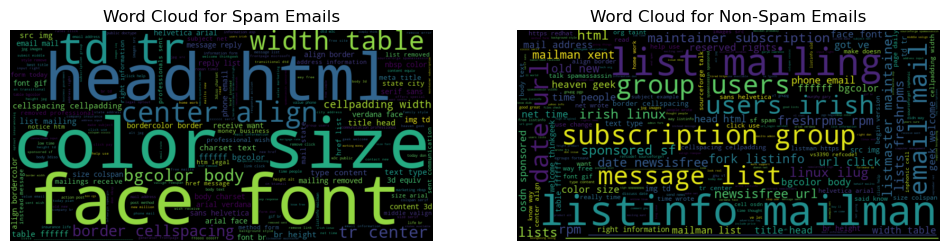

In [45]:
# Convert sparse matrix to dense array or extract feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get text for spam and non-spam emails
spam_text = ' '.join(feature_names[X_train_tf[y_train == 1].nonzero()[1]])
ham_text = ' '.join(feature_names[X_train_tf[y_train == 0].nonzero()[1]])

# Create WordCloud for Spam
wordcloud_spam = WordCloud(width=800, height=400).generate(spam_text)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title('Word Cloud for Spam Emails')
plt.axis('off')

# Create WordCloud for Non-Spam
wordcloud_ham = WordCloud(width=800, height=400).generate(ham_text)
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title('Word Cloud for Non-Spam Emails')
plt.axis('off')

plt.show()

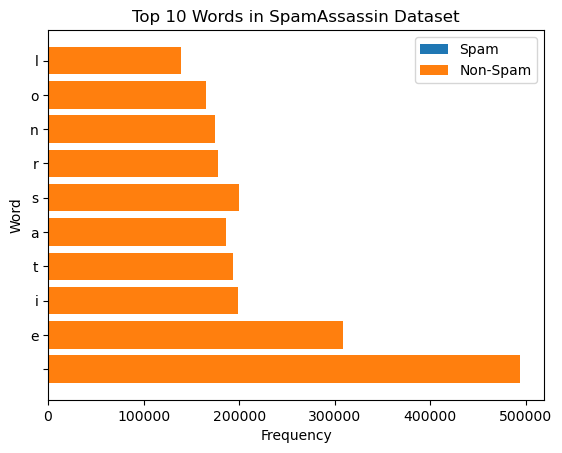

In [56]:
from collections import Counter

top_n = 10
counter_spam = Counter(spam_text)
counter_ham = Counter(ham_text)

top_words_spam = [word[0] for word in counter_spam.most_common(top_n)]
top_words_ham = [word[0] for word in counter_ham.most_common(top_n)]

plt.barh(top_words_spam, [counter_spam[word] for word in top_words_spam], label='Spam')
plt.barh(top_words_ham, [counter_ham[word] for word in top_words_ham], label='Non-Spam')
plt.title(f'Top {top_n} Words in SpamAssassin Dataset')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.legend()
plt.show()

### Naive Bayes Classifier

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [47]:
nb = GaussianNB()

In [48]:
#  cross-validation
cv_scores = cross_val_score(nb, X_tfidf.toarray(), y, cv=5, scoring='accuracy')

# Fit the model on the training data
nb.fit(X_train.toarray(), y_train)

# Step 8: Evaluate the model on the test data
accuracy = nb.score(X_test.toarray(), y_test)

# Display results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy: {:.2f}".format(cv_scores.mean()))
print("Accuracy on Test Set: {:.2f}".format(accuracy))

Cross-Validation Accuracy Scores: [0.985993   0.9929965  0.94144144 0.96246246 0.94894895]
Mean Accuracy: 0.97
Accuracy on Test Set: 0.97


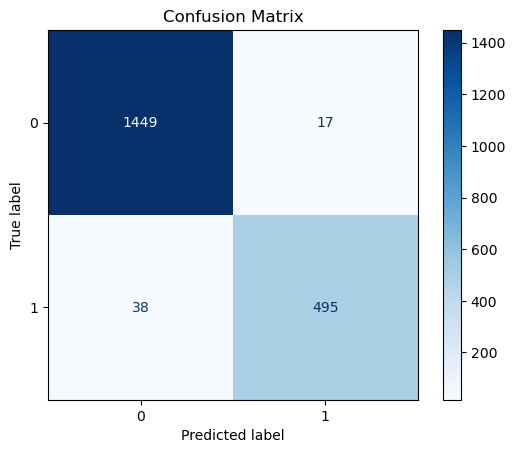

In [53]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
# Create a confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Create ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)

# Plot the confusion matrix
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

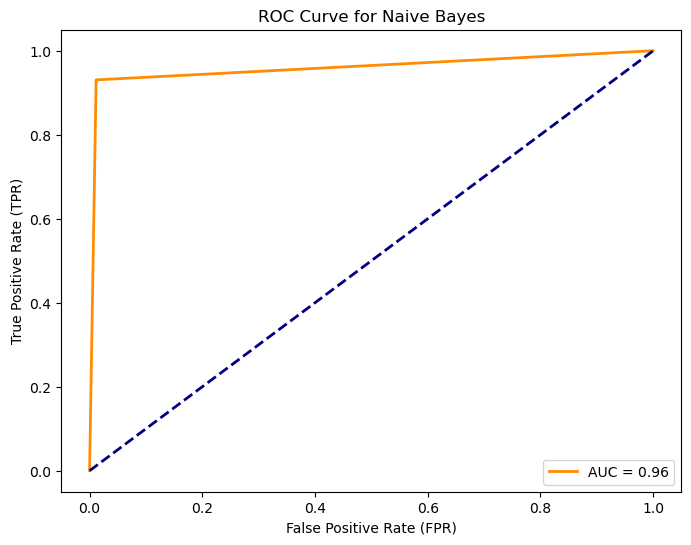

In [54]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_pred_prob = nb.predict_proba(X_test.toarray())[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Naive Bayes')
plt.legend(loc='lower right')
plt.show()

### Random Forest Model 

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
scorer = make_scorer(accuracy_score)
cv_scores = cross_val_score(rf, X_tfidf.toarray(), y, cv=5, scoring=scorer)

# Display cross-validation results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy: {:.2f}".format(cv_scores.mean()))

Cross-Validation Accuracy Scores: [0.99749875 0.99549775 0.96846847 0.97797798 0.97147147]
Mean Accuracy: 0.98


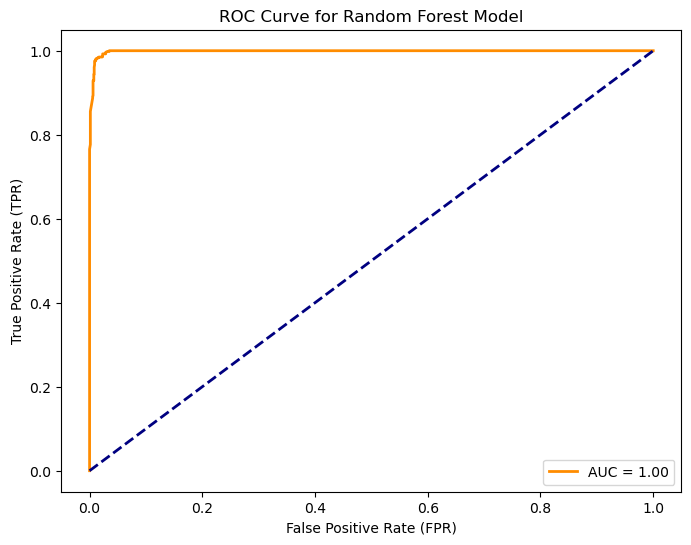

In [60]:
rf.fit(X_train, y_train)

# Get predicted probabilities for the positive class
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Random Forest Model')
plt.legend(loc='lower right')
plt.show()

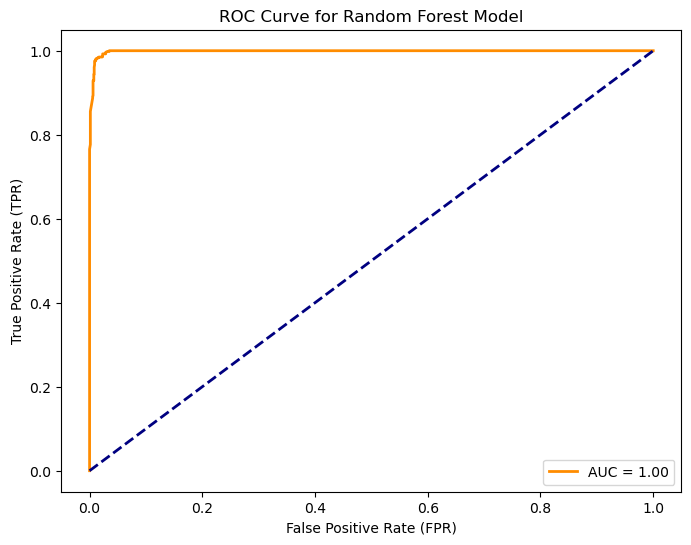

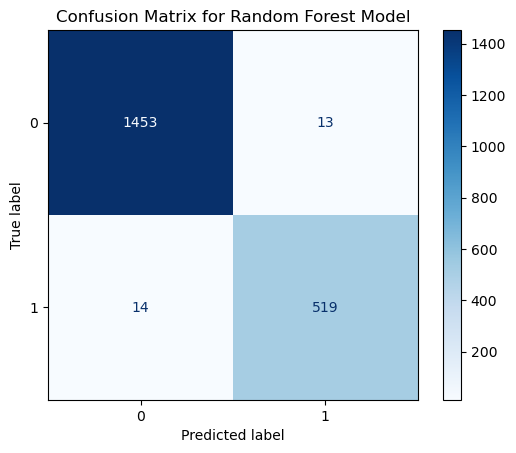

In [61]:
# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
threshold = 0.5
y_pred_rf = (y_pred_prob_rf >= threshold).astype(int)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Random Forest Model')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Create ConfusionMatrixDisplay
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=label_encoder.classes_)

# Plot the confusion matrix
cm_display_rf.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()